### Utils

In [1]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_pca(model):
  pca = PCA(n_components=2)
  pca_data = pca.fit_transform(model.WE.weight.data.cpu().numpy())

  plt.figure(figsize=(7, 7))
  for i, d in enumerate(pca_data):
    plt.scatter(d[0], d[1], alpha=0.5)
    plt.text(d[0], d[1], i)

  plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
  plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')
  plt.show()

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
def hm(data):
  sns.heatmap(data.cpu(), annot=True, cmap='viridis', square=True, center=0, fmt='.1f')
  plt.show()

### Global

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Transformer

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

class TF(nn.Module):
    def __init__(self, n_vocab=10, d_model=10):
        super(TF, self).__init__()
        torch.manual_seed(42)

        self.WE = nn.Embedding(n_vocab, d_model)
        # self.WQ = nn.Linear(d_model, d_model, bias=False)
        # self.WK = nn.Linear(d_model, d_model, bias=False)
        self.WV = nn.Linear(d_model, d_model, bias=False)
        self.W1 = nn.Linear(d_model, d_model, bias=False)
        # self.W2 = nn.Linear(d_model, d_model, bias=False)
        self.WL = nn.Linear(d_model, n_vocab, bias=False)

    def forward(self, x):
        batch_size, seq_len = x.shape
        E = self.WE(x) # E: (b, t, d_model)

        # Q = self.WQ(E)
        # K = self.WK(E)
        # att_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(E.size(-1))
        att_scores = torch.ones((seq_len, seq_len)) # Ablate Q, K

        att_weight = F.softmax(att_scores, dim=-1).to(device)

        V = self.WV(E)
        # V = E # Ablate WV

        att = torch.matmul(att_weight, V)

        # FNN = self.W2(F.relu(self.W1(att)))
        FNN = F.relu(self.W1(att)) # Ablate W2
        # FNN = self.W1(att) # Ablate W2+ReLU (X)
        # FNN = att # Ablate FFN (X)

        L = self.WL(FNN)

        return L[:,-1,:] # only next token

In [5]:
inputs = []
labels = []

for i in range(10):
    for j in range(10):
        inputs.append([i, j])
        labels.append((i + j) % 10)

inputs = torch.LongTensor(inputs).to(device)
labels = torch.LongTensor(labels).to(device)

dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [6]:
model = TF().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

print(sum(p.numel() for p in model.parameters()), 'parameters')

400 parameters


In [7]:
# WE = model.WE.weight.data.cpu().detach()

# import numpy as np
# base = 10

# y = np.cos(2 * np.pi * np.arange(base*2) / base)

# rad = 1
# for row in range(base):
#     for col in range(base):
#         WE[row, col] = rad * y[10+row-col]

# model.WE.weight.data = WE.to(device)
# model.WE.weight.requires_grad = False
# hm(model.WE.weight.data)

Epoch 1	 Loss: 2.304681	 Acc: 0.120000


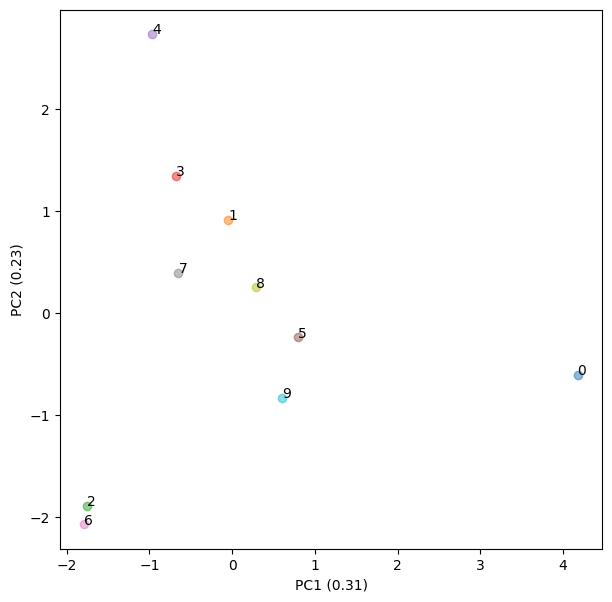

Epoch 100	 Loss: 2.247493	 Acc: 0.160000
Epoch 200	 Loss: 2.093553	 Acc: 0.250000
Epoch 300	 Loss: 1.876770	 Acc: 0.300000
Epoch 400	 Loss: 1.662261	 Acc: 0.410000
Epoch 500	 Loss: 1.352093	 Acc: 0.570000


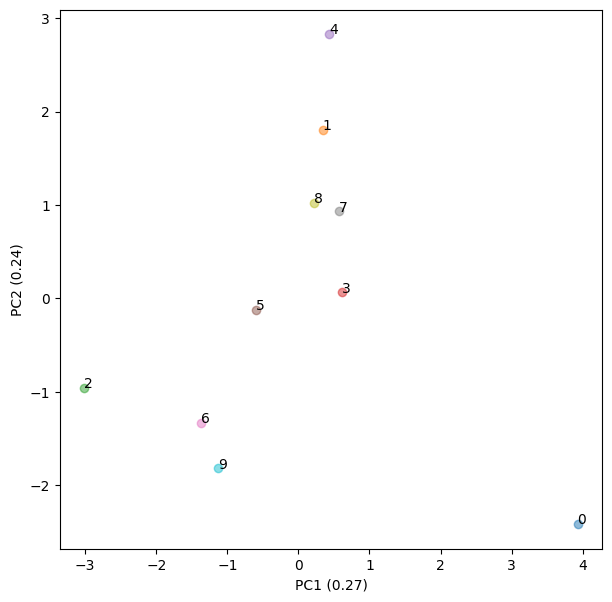

Epoch 600	 Loss: 0.955063	 Acc: 0.730000
Epoch 700	 Loss: 0.668527	 Acc: 0.870000
Epoch 800	 Loss: 0.476259	 Acc: 0.940000
Epoch 900	 Loss: 0.328513	 Acc: 1.000000
Epoch 1000	 Loss: 0.214688	 Acc: 1.000000


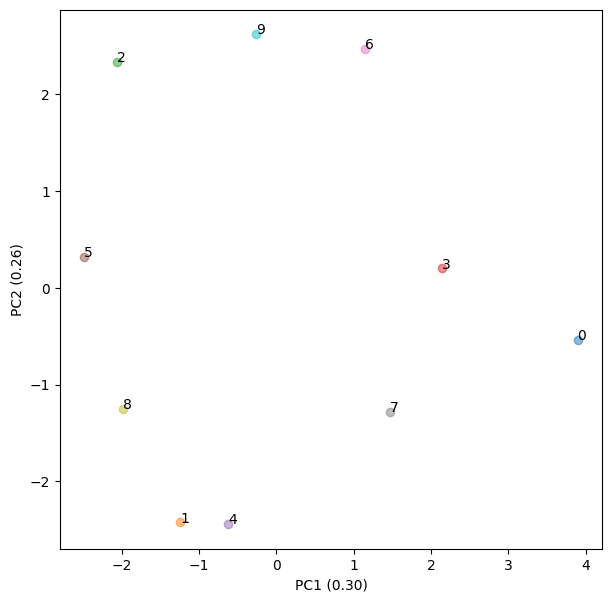

Epoch 1100	 Loss: 0.129235	 Acc: 1.000000
Epoch 1200	 Loss: 0.068265	 Acc: 1.000000
Epoch 1300	 Loss: 0.031446	 Acc: 1.000000
Epoch 1400	 Loss: 0.012301	 Acc: 1.000000
Epoch 1500	 Loss: 0.004482	 Acc: 1.000000


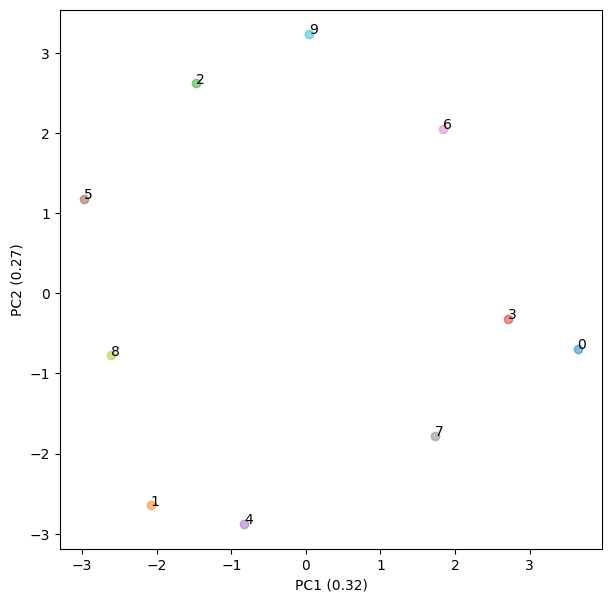

Epoch 1600	 Loss: 0.001529	 Acc: 1.000000
Epoch 1700	 Loss: 0.000471	 Acc: 1.000000
Epoch 1800	 Loss: 0.000131	 Acc: 1.000000
Epoch 1900	 Loss: 0.000032	 Acc: 1.000000
Epoch 2000	 Loss: 0.000007	 Acc: 1.000000


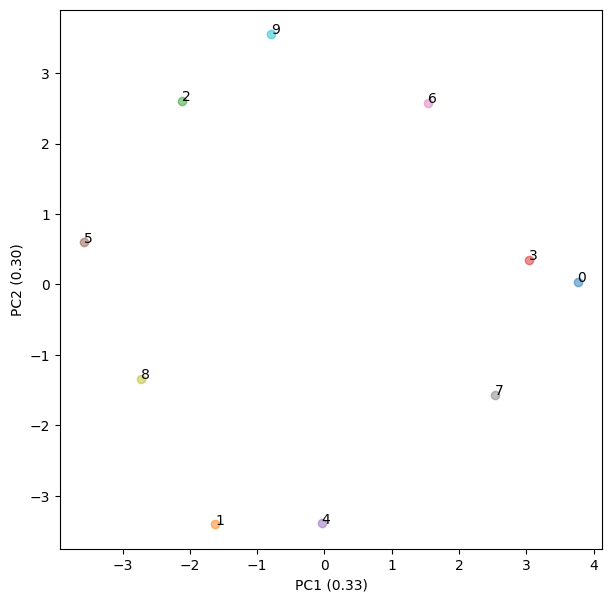

Epoch 2100	 Loss: 0.000001	 Acc: 1.000000
Epoch 2200	 Loss: 0.000000	 Acc: 1.000000
Epoch 2300	 Loss: 0.000000	 Acc: 1.000000
Epoch 2400	 Loss: 0.000000	 Acc: 1.000000
Epoch 2500	 Loss: 0.000000	 Acc: 1.000000


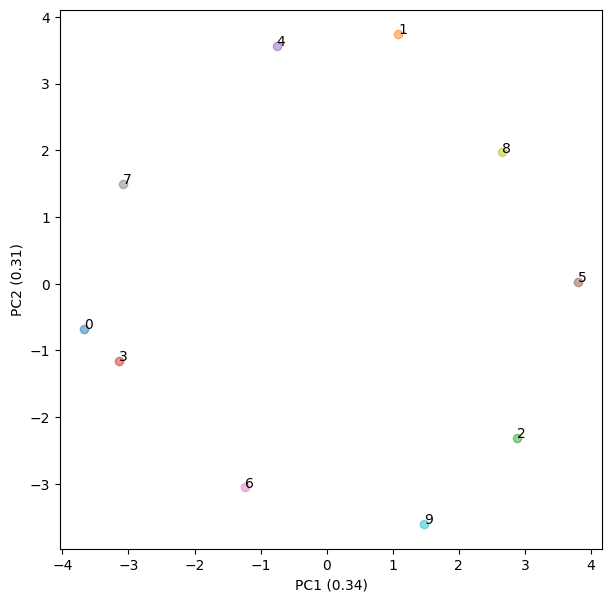

Epoch 2600	 Loss: 0.000000	 Acc: 1.000000
Epoch 2700	 Loss: 0.000000	 Acc: 1.000000
Epoch 2800	 Loss: 0.000000	 Acc: 1.000000
Epoch 2900	 Loss: 0.000000	 Acc: 1.000000
Epoch 3000	 Loss: 0.000000	 Acc: 1.000000


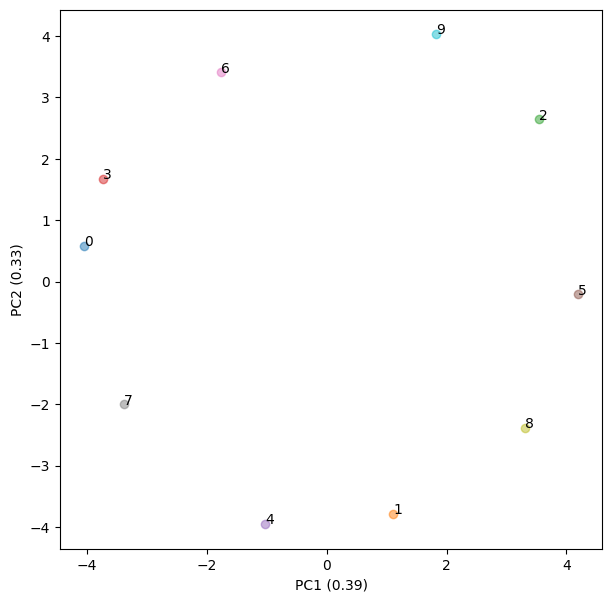

Epoch 3100	 Loss: 0.000000	 Acc: 1.000000
Epoch 3200	 Loss: 0.000000	 Acc: 1.000000
Epoch 3300	 Loss: 0.000000	 Acc: 1.000000
Epoch 3400	 Loss: 0.000000	 Acc: 1.000000
Epoch 3500	 Loss: 0.000000	 Acc: 1.000000


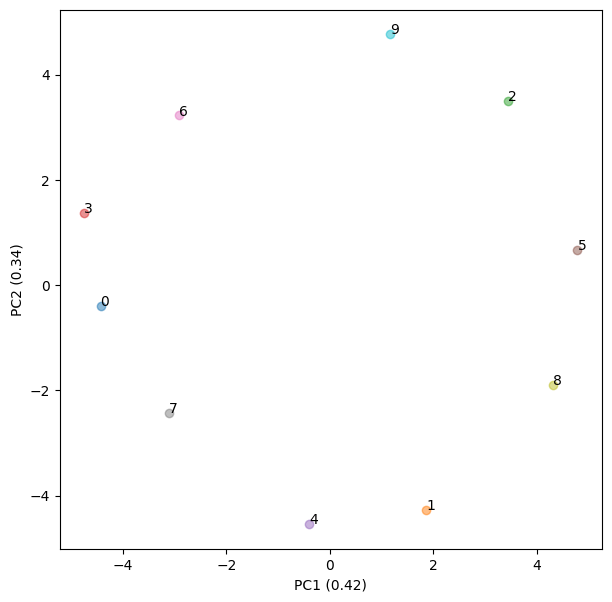

Epoch 3600	 Loss: 0.000000	 Acc: 1.000000
Epoch 3700	 Loss: 0.000000	 Acc: 1.000000
Epoch 3800	 Loss: 0.000000	 Acc: 1.000000
Epoch 3900	 Loss: 0.000000	 Acc: 1.000000
Epoch 4000	 Loss: 0.000000	 Acc: 1.000000


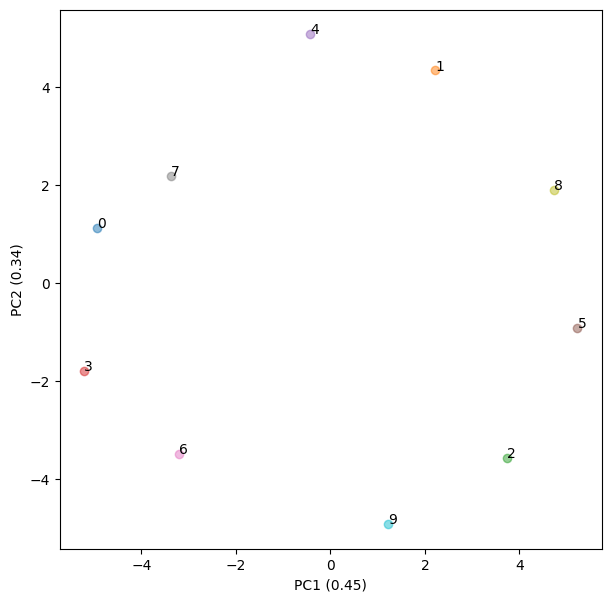

Epoch 4100	 Loss: 0.000000	 Acc: 1.000000
Epoch 4200	 Loss: 0.000000	 Acc: 1.000000
Epoch 4300	 Loss: 0.000000	 Acc: 1.000000
Epoch 4400	 Loss: 0.000000	 Acc: 1.000000
Epoch 4500	 Loss: 0.000000	 Acc: 1.000000


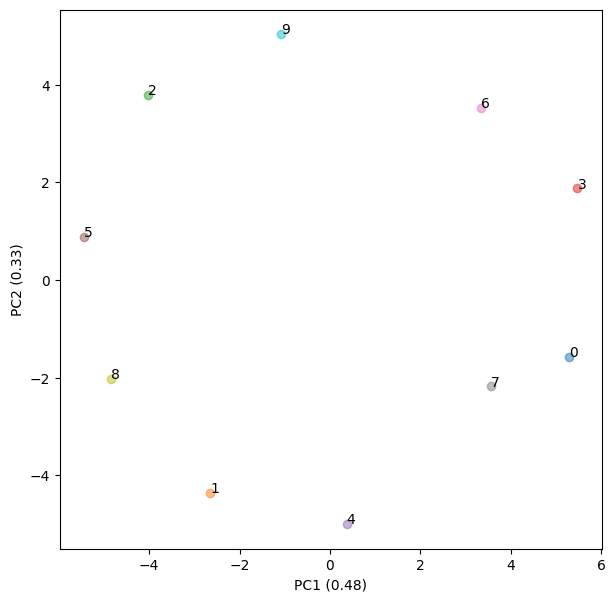

Epoch 4600	 Loss: 0.000000	 Acc: 1.000000
Epoch 4700	 Loss: 0.000000	 Acc: 1.000000
Epoch 4800	 Loss: 0.000000	 Acc: 1.000000
Epoch 4900	 Loss: 0.000000	 Acc: 1.000000
Epoch 5000	 Loss: 0.000000	 Acc: 1.000000


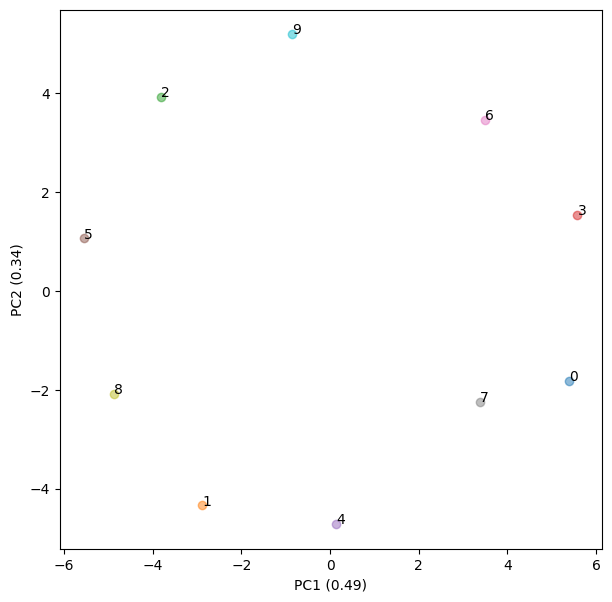

In [8]:
epochs = 5000

losses = []
for epoch in range(epochs):
    model.train()
    total = correct = loss_sum = 0
    for batch, (x, y) in enumerate(dataloader):

        optimizer.zero_grad()

        pred = model(x)
        total += len(y)
        correct += (torch.argmax(pred, dim=1) == y).count_nonzero()
        loss = loss_fn(pred, y)
        loss_sum += loss.item()

        loss.backward()

        optimizer.step()

        # # Weight clamp
        # with torch.no_grad():
        #   for param in model.parameters():
        #     param.clamp_(min=-1, max=1)

    losses.append(loss_sum/total)
    if epoch == 0 or (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}\t Loss: {losses[-1]:6f}\t Acc: {correct/total:4f}")
    if epoch == 0 or (epoch+1) % 500 == 0:
        plot_pca(model)
        pass

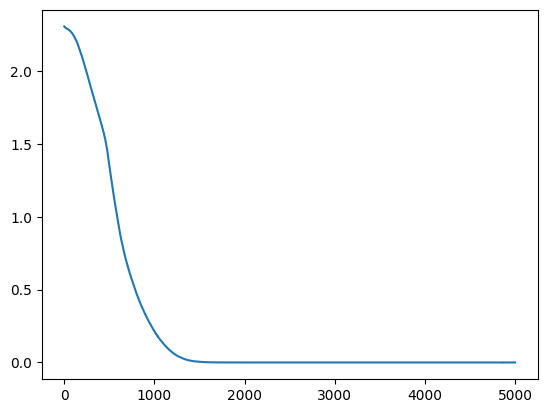

In [9]:
plt.plot(losses)

In [10]:
model.eval()
with torch.no_grad():
    pred = model(inputs)
    labels = torch.argmax(pred, dim=1)

err = 0
for i in range(100):
  if inputs[i].data.sum().item() % 10 != labels[i].item():
    err += 1
    print(inputs[i], labels[i])
print('Error: ', err)

Error:  0


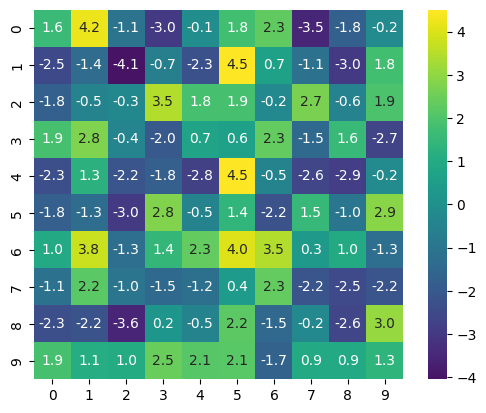

In [11]:
hm(model.WE.weight.data)

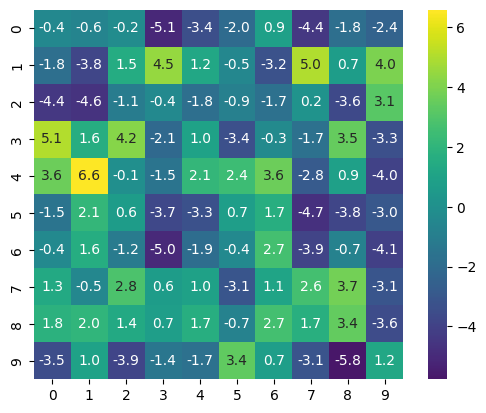

In [12]:
hm(model.WV.weight.data)

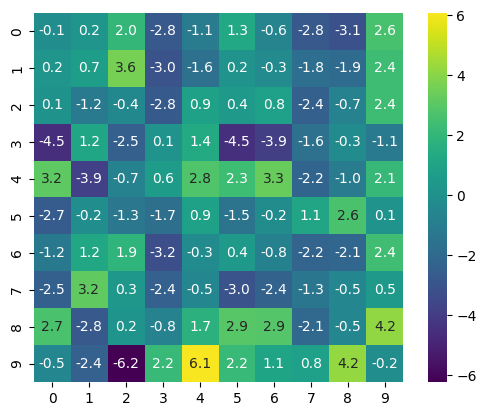

In [13]:
hm(model.W1.weight.data)

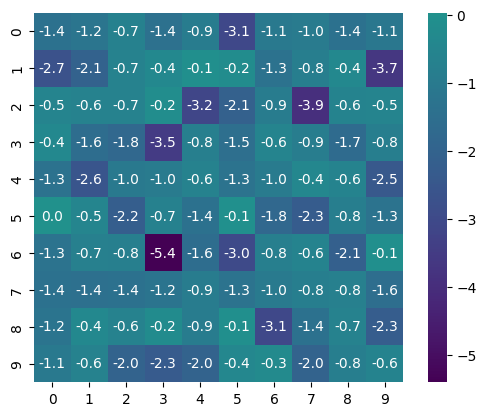

In [14]:
hm(model.WL.weight.data)